In [54]:
import scipy as sc
import numpy as np
import matplotlib.pyplot as plt
from cellpose import models
import os
from czifile import imread
import skimage as sk



Generate list of images per group

In [55]:
# Define the folder location
folderLoc = os.path.join(os.path.dirname(os.getcwd()), r'Raw_Datasets\Super_Res\2023-06-21')


# Initialize the main dictionary
imageDict = {}
imageDict['Control'] = {}
imageDict['GSK'] = {}

# Get the names of all directories in folderLoc
timepointDirs = [name for name in os.listdir(folderLoc) if os.path.isdir(os.path.join(folderLoc, name)) and name.startswith('TIMEPOINT')]

# Iterate over each timepoint directory
for timepointDir in timepointDirs:
    # Initialize the nested dictionary for each timepoint
    imageDict['Control'][timepointDir] = {}
    imageDict['GSK'][timepointDir] = {}
    
    # Get the paths to each .czi file that begins with C or G
    cziFiles = [os.path.join(folderLoc, timepointDir, file) for file in os.listdir(os.path.join(folderLoc, timepointDir)) if file.startswith(('C', 'G')) and file.endswith('.czi')]

    # Add the paths to the nested dictionary
    for cziFile in cziFiles:
        mainKey = 'Control' if os.path.basename(cziFile).startswith('C') else 'GSK'
        imageDict[mainKey][timepointDir][os.path.basename(cziFile)] = cziFile
    

# Print the resulting dictionary
print(imageDict)


{'Control': {'TIMEPOINT 1 T 0 MIN': {'C1_T1.czi': 'c:\\Users\\Jack\\Documents\\GitHub\\Chromatin_Remodeling_Image_Processing\\Raw_Datasets\\Super_Res\\2023-06-21\\TIMEPOINT 1 T 0 MIN\\C1_T1.czi', 'C2_T1.czi': 'c:\\Users\\Jack\\Documents\\GitHub\\Chromatin_Remodeling_Image_Processing\\Raw_Datasets\\Super_Res\\2023-06-21\\TIMEPOINT 1 T 0 MIN\\C2_T1.czi', 'C3_T1.czi': 'c:\\Users\\Jack\\Documents\\GitHub\\Chromatin_Remodeling_Image_Processing\\Raw_Datasets\\Super_Res\\2023-06-21\\TIMEPOINT 1 T 0 MIN\\C3_T1.czi', 'C4_T1.czi': 'c:\\Users\\Jack\\Documents\\GitHub\\Chromatin_Remodeling_Image_Processing\\Raw_Datasets\\Super_Res\\2023-06-21\\TIMEPOINT 1 T 0 MIN\\C4_T1.czi', 'C5_T1.czi': 'c:\\Users\\Jack\\Documents\\GitHub\\Chromatin_Remodeling_Image_Processing\\Raw_Datasets\\Super_Res\\2023-06-21\\TIMEPOINT 1 T 0 MIN\\C5_T1.czi'}, 'TIMEPOINT 2 T 45 MIN': {'C1_T2.czi': 'c:\\Users\\Jack\\Documents\\GitHub\\Chromatin_Remodeling_Image_Processing\\Raw_Datasets\\Super_Res\\2023-06-21\\TIMEPOINT 2 T 45

Load in 1 Image

In [56]:
img = imread(imageDict['Control']['TIMEPOINT 1 T 0 MIN']['C2_T1.czi'])
img.shape

(1, 1, 61, 1248, 1248, 1)

Show single img

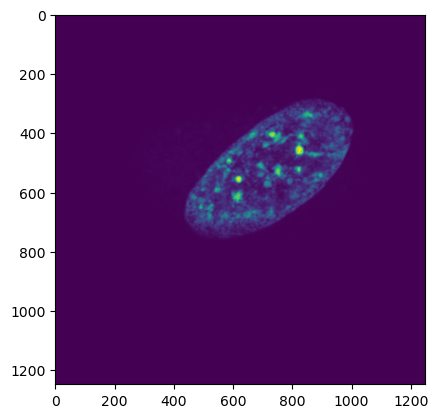

In [57]:
plt.imshow(np.array(img[0, 0, 32, :, :, 0]))
plt.show()

Max Projection

In [110]:
z_range = np.arange(int(np.round(img.shape[2]/2-5)), int(np.round(img.shape[2]/2+5)))
img_max = np.max(img[0, 0, z_range, :, :, 0], axis=0) # middle z-slice max projection
#img_max = np.max(img[0, 0, :, :, :, 0], axis=0) # max projection of all slices

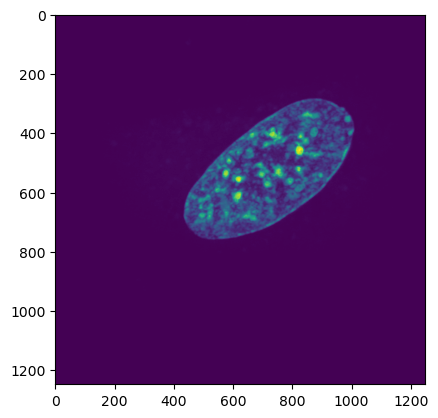

In [111]:
plt.imshow(img_max)
plt.show()

Mask Nucleous 

In [60]:
# RUN CELLPOSE
model = models.Cellpose(model_type='nuclei', net_avg=True, gpu=True) # model_type='cyto' or model_type='nuclei'
masks, flow, style, diams  = model.eval(img_max,channels=[0,0], diameter=1000)

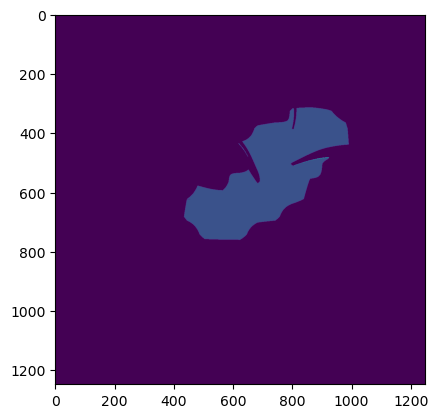

In [61]:
plt.imshow(masks)
plt.show()
# This is hot trash

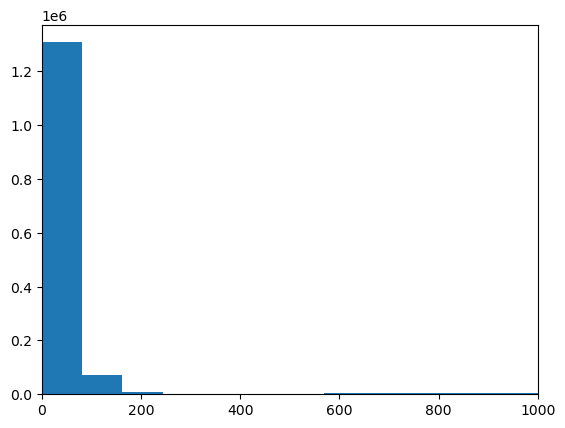

In [112]:
plt.hist(img_max.flatten(), bins=100)
plt.xlim([0, 1000])
plt.show()

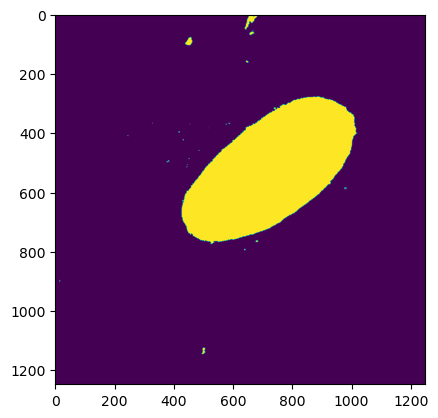

In [63]:
mask = img_max > 300
plt.imshow(mask)
plt.show()

In [113]:
mask =sk.morphology.remove_small_holes(mask, area_threshold=200, connectivity=1)
mask = sk.morphology.remove_small_objects(mask, min_size=1000, connectivity=1)

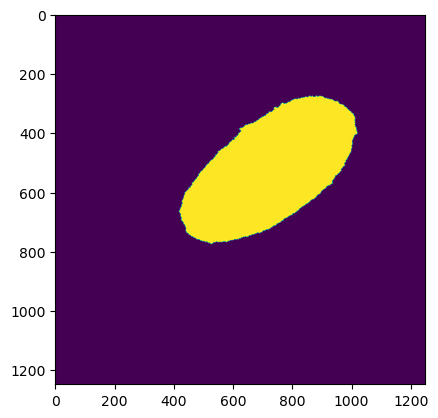

In [114]:
plt.imshow(mask)
plt.show()

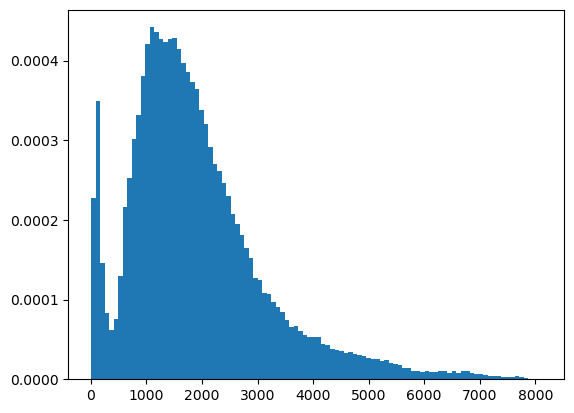

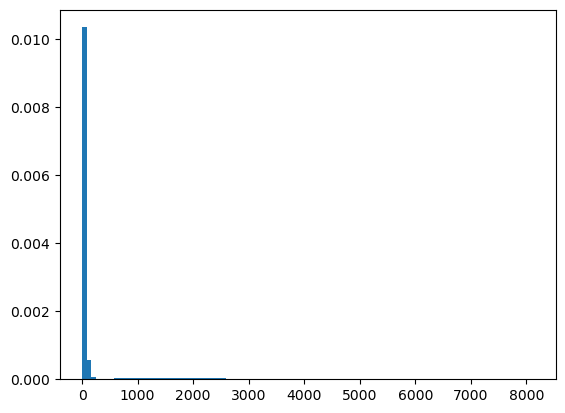

In [115]:
plt.hist(img_max[mask], bins=100, density=True)
plt.show()
plt.hist(img_max.flatten(), bins=100, density=True)
plt.show()

In [116]:
from scipy.optimize import curve_fit

def find_threshold(image, epsilon):
    # Flatten the image
    flattened_image = image.flatten()

    # Calculate the histogram of pixel values
    hist, bins = np.histogram(flattened_image, density=True, bins=256)

    # Define the exponential decay function
    def exponential_decay(x, a, b):
        return a * np.exp(-b * x)

    # Fit the histogram to the exponential decay function
    popt, _ = curve_fit(exponential_decay, bins[:-1], hist, p0=[0.002, 0.001])

    # Find the threshold value when the distribution is epsilon away from 0
    threshold = np.where(exponential_decay(bins[:-1], *popt) < epsilon)
    plt.plot(bins[:-1], hist)
    plt.plot(bins[:-1], exponential_decay(bins[:-1], *popt))
    plt.xlim([0, 1000])
    plt.show()
    return bins[:-1][threshold]


In [117]:
'''import math
def find_threshold_poisson(image, epsilon):
    # Flatten the image
    flattened_image = image.flatten()

    # Calculate the histogram of pixel values
    hist, bins = np.histogram(flattened_image, density=True, bins=256)

    # Define the exponential decay function
    def exponential_decay(x, g1, g2):
        return (np.exp(-g1)*g1**x)/math.factorial(x) + (np.exp(-g2)*g2**x)/math.factorial(x)

    # Fit the histogram to the exponential decay function
    popt, _ = curve_fit(exponential_decay, bins[:-1], hist, p0=[50, 2000])

    # Find the threshold value when the distribution is epsilon away from 0
    threshold = np.where(exponential_decay(bins[:-1], *popt) < epsilon)
    plt.plot(bins[:-1], hist)
    plt.plot(bins[:-1], exponential_decay(bins[:-1], *popt))
    plt.xlim([0, 1000])
    plt.show()
    return bins[:-1][threshold]'''

'import math\ndef find_threshold_poisson(image, epsilon):\n    # Flatten the image\n    flattened_image = image.flatten()\n\n    # Calculate the histogram of pixel values\n    hist, bins = np.histogram(flattened_image, density=True, bins=256)\n\n    # Define the exponential decay function\n    def exponential_decay(x, g1, g2):\n        return (np.exp(-g1)*g1**x)/math.factorial(x) + (np.exp(-g2)*g2**x)/math.factorial(x)\n\n    # Fit the histogram to the exponential decay function\n    popt, _ = curve_fit(exponential_decay, bins[:-1], hist, p0=[50, 2000])\n\n    # Find the threshold value when the distribution is epsilon away from 0\n    threshold = np.where(exponential_decay(bins[:-1], *popt) < epsilon)\n    plt.plot(bins[:-1], hist)\n    plt.plot(bins[:-1], exponential_decay(bins[:-1], *popt))\n    plt.xlim([0, 1000])\n    plt.show()\n    return bins[:-1][threshold]'

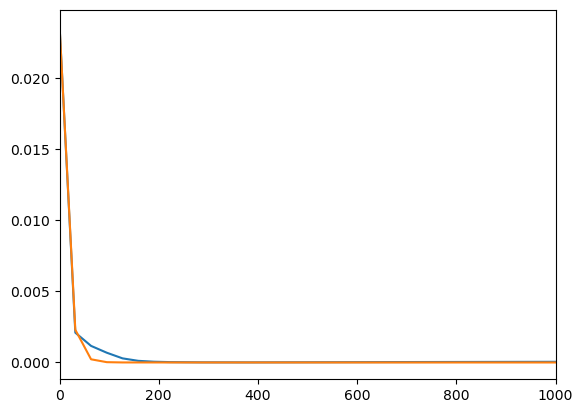

126.859375


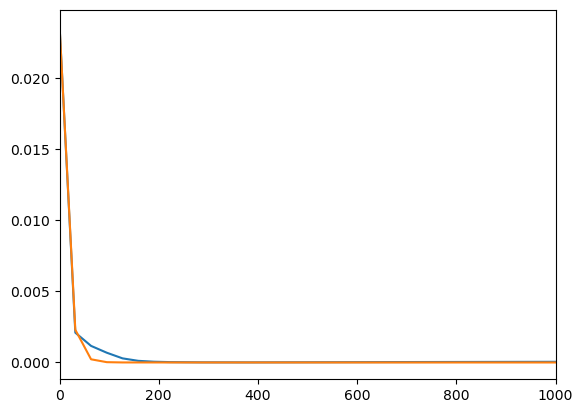

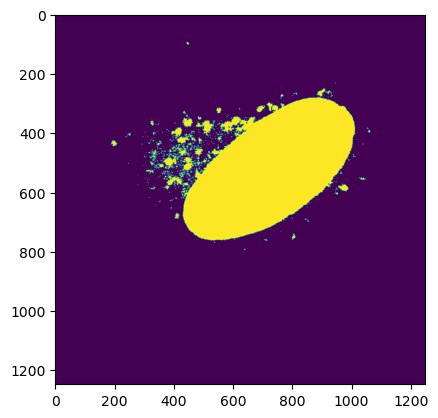

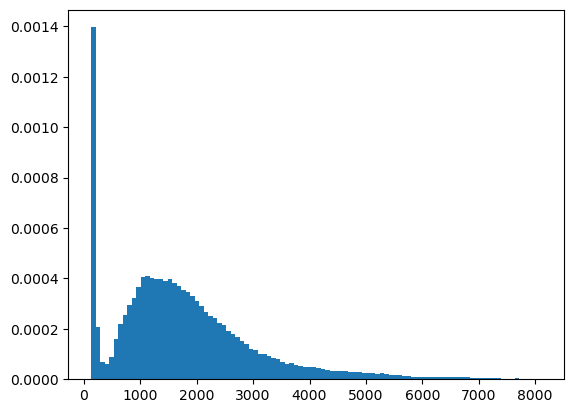

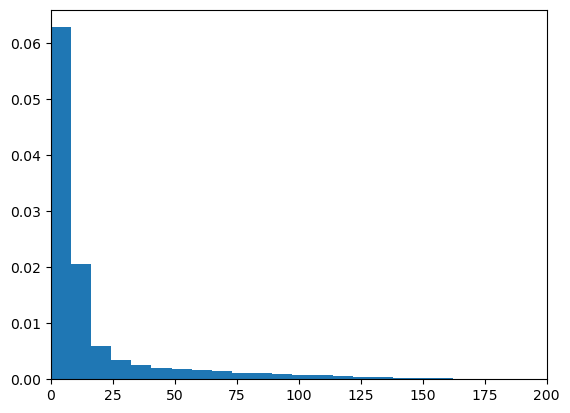

In [121]:
print(find_threshold(img_max, 0.00001)[0])
threshold = find_threshold(img_max, 0.00001)[0]
mask = img_max > threshold
plt.imshow(mask)
plt.show()
plt.hist(img_max[mask], bins=100, density=True)
plt.show()
plt.hist(img_max.flatten(), bins=1000, density=True)
plt.show()


In [119]:
mask = sk.segmentation.clear_border(mask)
mask =sk.morphology.remove_small_holes(mask, area_threshold=200, connectivity=1)
mask = sk.morphology.remove_small_objects(mask, min_size=1000, connectivity=1)
mask = sk.morphology.binary_erosion(mask)
mask = sk.morphology.binary_dilation(mask)

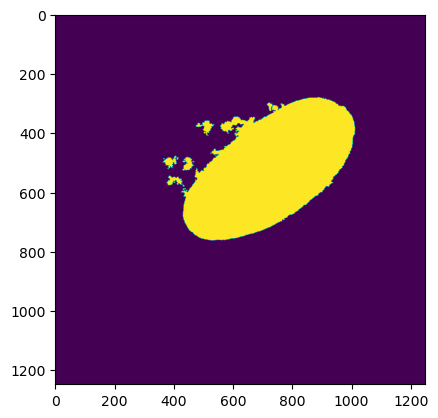

In [120]:
plt.imshow(mask)
plt.show()

In [109]:
labeled_mask = sk.measure.label(mask)
cell_props = sk.measure.regionprops(labeled_mask)